# Демонстрация анализа КТГ (Кардиотокографии)

Комплексный анализ сигналов КТГ для выявления всех сущностей и классификации состояний плода.

## Возможности системы:

### 🔍 **Извлечение сущностей:**
1. **Базальная ЧСС** - определение базального ритма с исключением акцелераций/децелераций
2. **Вариабельность** - кратко- и долговременная, классификация типов кривых
3. **Акцелерации** - детекция и оценка реактивности (NST)
4. **Децелерации** - классификация на ранние, поздние, вариабельные, пролонгированные
5. **Маточная активность** - анализ схваток и тонуса
6. **Артефакты** - детекция потери сигнала, выбросов, шума

### 🏥 **Медицинская классификация:**
- Оценка по шкале **Фишера** (0-8 баллов)
- Классификация по **FIGO** (нормальный/сомнительный/патологический)
- Выявление **гипоксии** по стадиям
- Детекция **тахи-/брадикардии** с оценкой компенсации
- Анализ **синусоидальных ритмов**
- Оценка **ареактивного НСТ**


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')

# Импорт наших модулей
from ctg_analysis import CTGAnalyzer
from ctg_data_processor import CTGDataProcessor

# Настройка визуализации
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12


## 1. Демонстрация на симулированных данных

Сначала продемонстрируем работу анализатора на симулированных КТГ данных с известными характеристиками.


In [5]:
# Создание симулированных данных КТГ
def create_ctg_simulation(duration_minutes=30, condition='normal'):
    """
    Создание симулированных КТГ данных
    
    Args:
        duration_minutes: Длительность записи в минутах
        condition: 'normal', 'hypoxia', 'tachycardia', 'bradycardia'
    """
    sampling_rate = 4.0
    n_samples = int(duration_minutes * 60 * sampling_rate)
    time_axis = np.linspace(0, duration_minutes * 60, n_samples)
    
    # Базовые параметры в зависимости от состояния
    if condition == 'normal':
        baseline = 140
        variability_amplitude = 10
        artifact_probability = 0.005
        acceleration_probability = 0.02
        deceleration_probability = 0.005
    elif condition == 'hypoxia':
        baseline = 155  # Легкая тахикардия
        variability_amplitude = 3   # Сниженная вариабельность
        artifact_probability = 0.01
        acceleration_probability = 0.005  # Мало акцелераций
        deceleration_probability = 0.03   # Больше децелераций
    elif condition == 'tachycardia':
        baseline = 175
        variability_amplitude = 8
        artifact_probability = 0.005
        acceleration_probability = 0.015
        deceleration_probability = 0.01
    elif condition == 'bradycardia':
        baseline = 95
        variability_amplitude = 4
        artifact_probability = 0.005
        acceleration_probability = 0.005
        deceleration_probability = 0.008
    
    # Долговременная вариабельность (медленные осцилляции)
    ltv = variability_amplitude * np.sin(2 * np.pi * time_axis / 60)  # 1 цикл в минуту
    
    # Кратковременная вариабельность (быстрые изменения)
    stv = 2 * np.random.randn(n_samples)
    
    # Тренд (постепенное изменение)
    if condition == 'hypoxia':
        trend = 10 * (time_axis / (duration_minutes * 60))  # Нарастающая тахикардия
    else:
        trend = 0
    
    # Базовый сигнал
    fhr_signal = baseline + ltv + stv + trend
    
    # Добавляем акцелерации
    acceleration_mask = np.random.random(n_samples) < acceleration_probability
    for i in range(len(acceleration_mask)):
        if acceleration_mask[i]:
            acc_duration = int(30 * sampling_rate)  # 30 секунд
            end_idx = min(i + acc_duration, n_samples)
            # Форма акцелерации
            acc_shape = 20 * np.exp(-np.arange(end_idx - i) / (10 * sampling_rate))
            fhr_signal[i:end_idx] += acc_shape
    
    # Добавляем децелерации
    deceleration_mask = np.random.random(n_samples) < deceleration_probability
    for i in range(len(deceleration_mask)):
        if deceleration_mask[i]:
            decel_duration = int(45 * sampling_rate)  # 45 секунд
            end_idx = min(i + decel_duration, n_samples)
            # Форма децелерации
            if condition == 'hypoxia':
                # Поздние децелерации - более опасные
                decel_shape = -25 * np.exp(-((np.arange(end_idx - i) - decel_duration//3) ** 2) / (2 * (decel_duration//6) ** 2))
            else:
                # Вариабельные децелерации
                decel_shape = -15 * np.exp(-((np.arange(end_idx - i) - decel_duration//2) ** 2) / (2 * (decel_duration//6) ** 2))
            fhr_signal[i:end_idx] += decel_shape
    
    # Добавляем артефакты
    artifact_mask = np.random.random(n_samples) < artifact_probability
    for i in range(len(artifact_mask)):
        if artifact_mask[i]:
            # Потеря сигнала на 30 секунд
            artifact_duration = int(30 * sampling_rate)
            end_idx = min(i + artifact_duration, n_samples)
            fhr_signal[i:end_idx] = 0
    
    # Ограничиваем физиологическими пределами
    fhr_signal = np.clip(fhr_signal, 50, 220)
    
    # Создаем маточную активность
    uc_signal = np.zeros(n_samples)
    # Схватки каждые 3-4 минуты
    for contraction_time in range(0, duration_minutes, 4):
        start_idx = int(contraction_time * 60 * sampling_rate)
        if start_idx < n_samples:
            contraction_duration = int(60 * sampling_rate)  # 1 минута
            end_idx = min(start_idx + contraction_duration, n_samples)
            # Форма схватки
            contraction_shape = 50 * np.exp(-((np.arange(end_idx - start_idx) - contraction_duration//2) ** 2) / (2 * (contraction_duration//6) ** 2))
            uc_signal[start_idx:end_idx] += contraction_shape
    
    return {
        'fhr': fhr_signal,
        'uc': uc_signal,
        'time': time_axis,
        'sampling_rate': sampling_rate,
        'condition': condition,
        'true_baseline': baseline,
        'true_variability': variability_amplitude
    }

# Создаем примеры разных состояний
print("Создание симулированных КТГ данных...")

# Нормальное состояние
normal_data = create_ctg_simulation(30, 'normal')
print(f"✅ Создан нормальный КТГ (baseline={normal_data['true_baseline']}, variability={normal_data['true_variability']})")

# Гипоксия
hypoxia_data = create_ctg_simulation(30, 'hypoxia')
print(f"⚠️  Создан КТГ с гипоксией (baseline={hypoxia_data['true_baseline']}, variability={hypoxia_data['true_variability']})")

# Тахикардия
tachy_data = create_ctg_simulation(30, 'tachycardia')
print(f"🔺 Создан КТГ с тахикардией (baseline={tachy_data['true_baseline']})")

# Брадикардия
brady_data = create_ctg_simulation(30, 'bradycardia')
print(f"🔻 Создан КТГ с брадикардией (baseline={brady_data['true_baseline']})")


Создание симулированных КТГ данных...
✅ Создан нормальный КТГ (baseline=140, variability=10)
⚠️  Создан КТГ с гипоксией (baseline=155, variability=3)
🔺 Создан КТГ с тахикардией (baseline=175)
🔻 Создан КТГ с брадикардией (baseline=95)


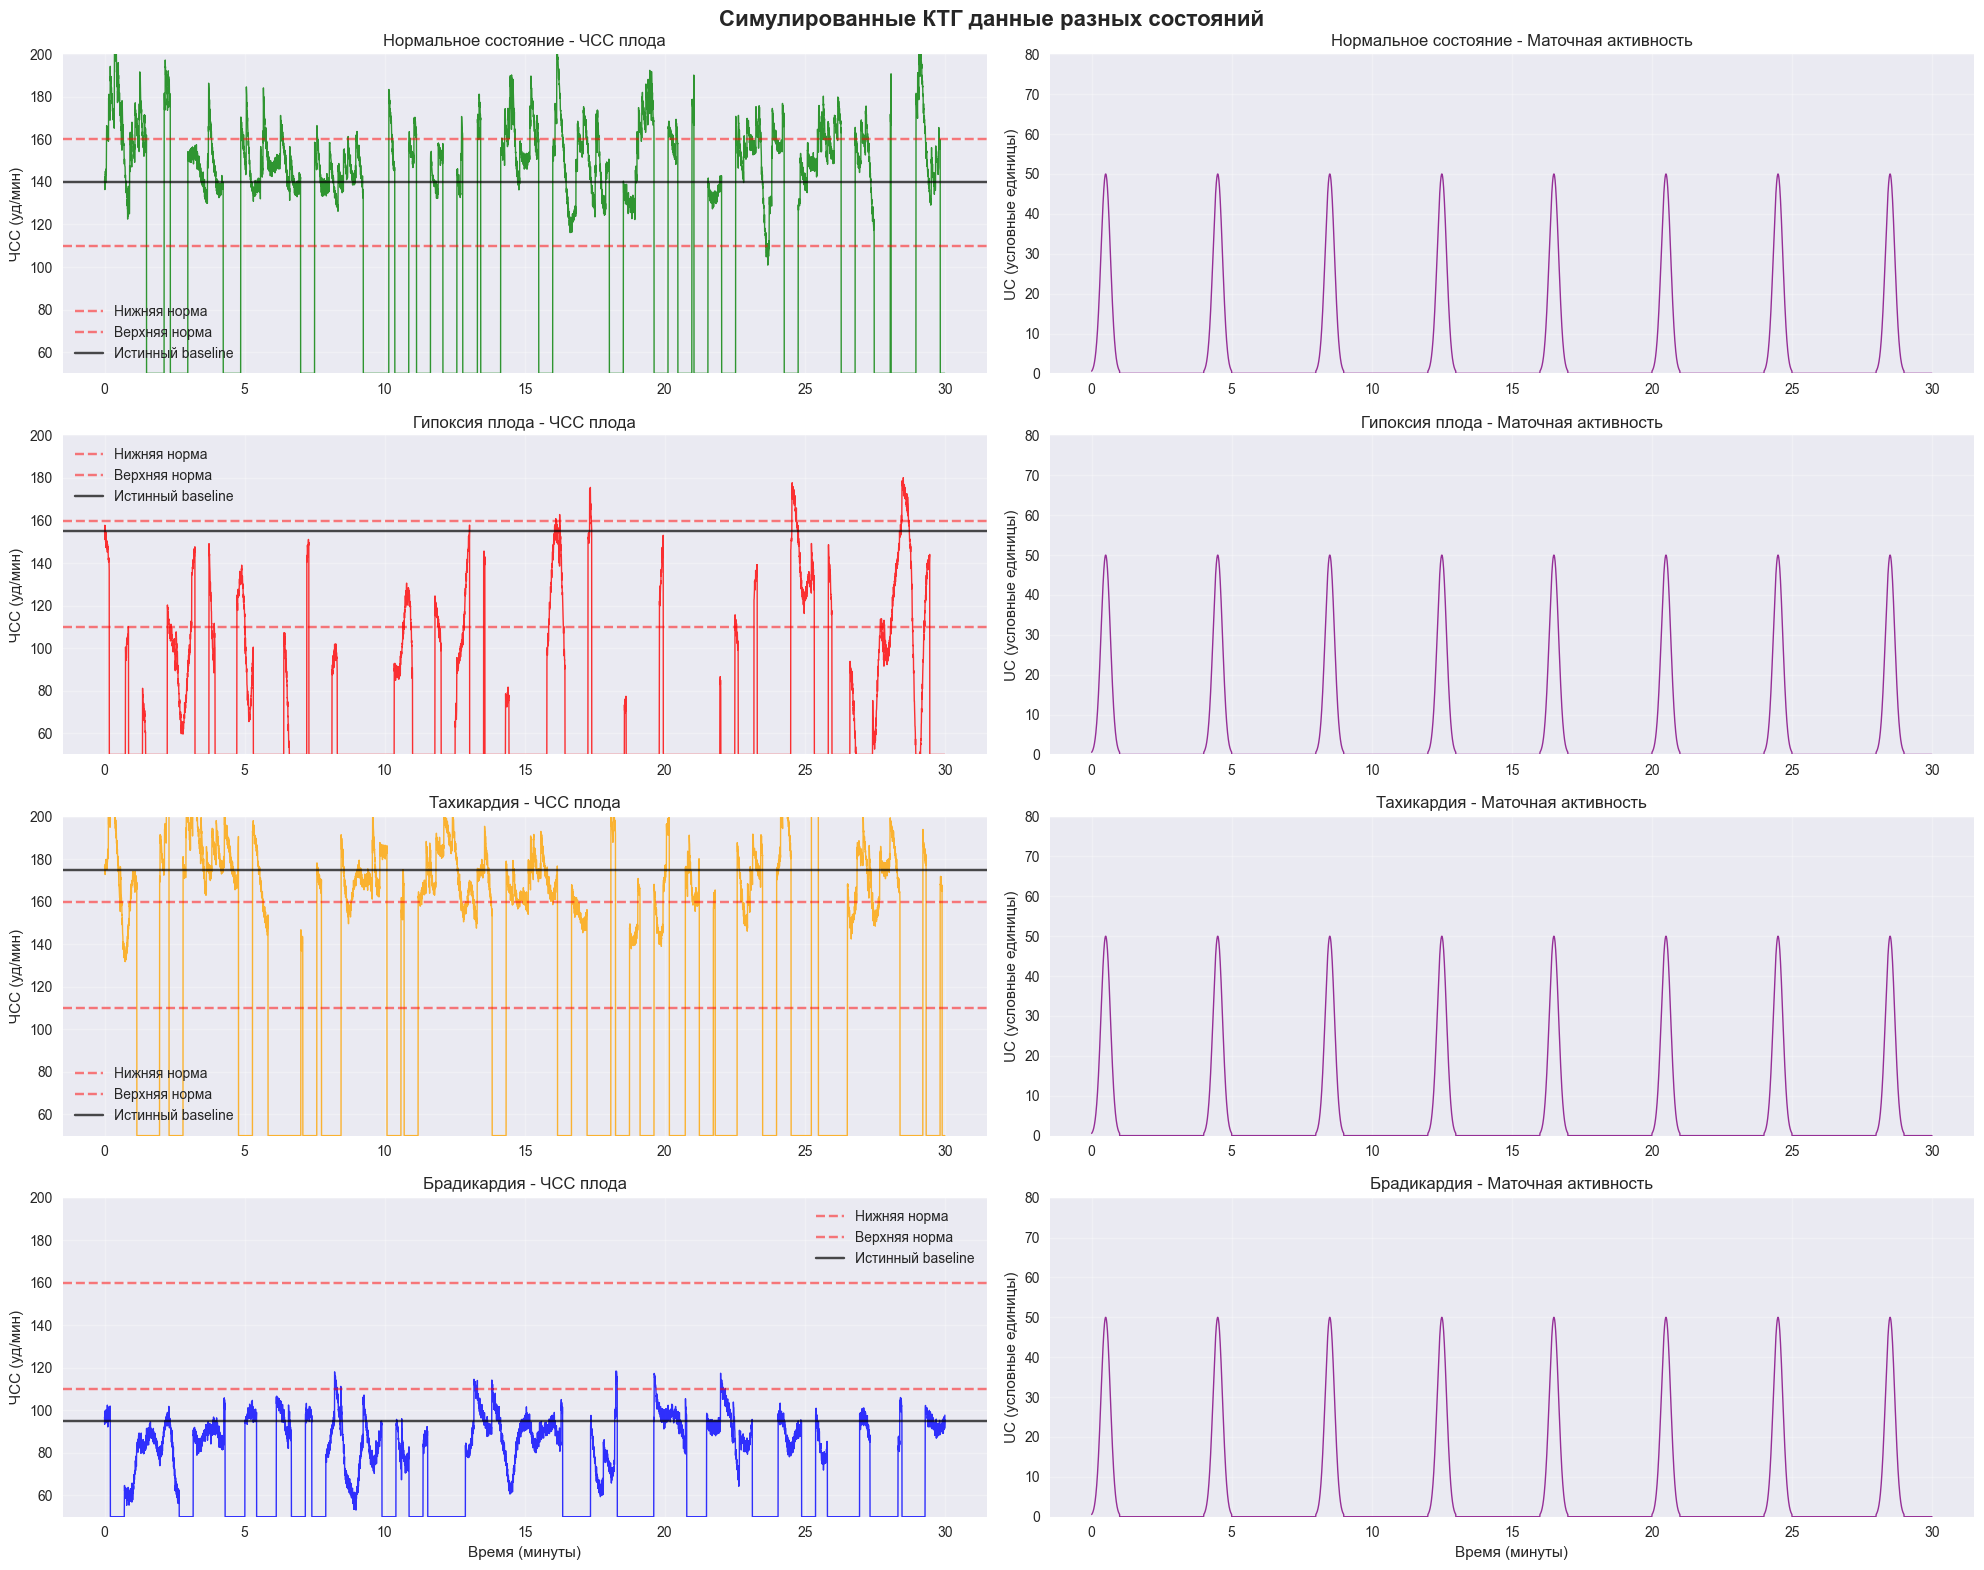

📊 Визуализация завершена. Видны характерные особенности каждого состояния:


In [6]:
# Визуализация симулированных данных
fig, axes = plt.subplots(4, 2, figsize=(20, 16))
fig.suptitle('Симулированные КТГ данные разных состояний', fontsize=16, fontweight='bold')

datasets = [
    (normal_data, 'Нормальное состояние', 'green'),
    (hypoxia_data, 'Гипоксия плода', 'red'),
    (tachy_data, 'Тахикардия', 'orange'),
    (brady_data, 'Брадикардия', 'blue')
]

for i, (data, title, color) in enumerate(datasets):
    # График ЧСС
    axes[i, 0].plot(data['time'] / 60, data['fhr'], color=color, alpha=0.8, linewidth=1)
    axes[i, 0].axhline(y=110, color='red', linestyle='--', alpha=0.5, label='Нижняя норма')
    axes[i, 0].axhline(y=160, color='red', linestyle='--', alpha=0.5, label='Верхняя норма')
    axes[i, 0].axhline(y=data['true_baseline'], color='black', linestyle='-', alpha=0.7, label=f'Истинный baseline')
    axes[i, 0].set_title(f'{title} - ЧСС плода')
    axes[i, 0].set_ylabel('ЧСС (уд/мин)')
    axes[i, 0].set_ylim(50, 200)
    axes[i, 0].grid(True, alpha=0.3)
    axes[i, 0].legend()
    
    # График маточной активности
    axes[i, 1].plot(data['time'] / 60, data['uc'], color='purple', alpha=0.8, linewidth=1)
    axes[i, 1].set_title(f'{title} - Маточная активность')
    axes[i, 1].set_ylabel('UC (условные единицы)')
    axes[i, 1].set_ylim(0, 80)
    axes[i, 1].grid(True, alpha=0.3)
    
    # Подписи времени только для нижних графиков
    if i == 3:
        axes[i, 0].set_xlabel('Время (минуты)')
        axes[i, 1].set_xlabel('Время (минуты)')

plt.tight_layout()
plt.show()

print("📊 Визуализация завершена. Видны характерные особенности каждого состояния:")
